## Dataset Tools - OSM to GeoJSON + Visualizer
This notebook is used to convert OSM data to GeoJSON. Only the geometry related data along with type of the geometries is preserved.

Unnecessary/unrelated data in the OSM set is removed during conversion. The notebook also contains interactive visualization of the data.

In [1]:
#%pip install osmnx
#%pip install folium
#%pip install tqdm
import osmnx as ox
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import folium
import shapely
import os
import seaborn as sns

Documentation for osmnx (used for downloading the data): https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.geometries 

OSM data model explained (nodes, ways, relations): https://labs.mapbox.com/mapping/osm-data-model/

Plotting polygons with Folium: https://geopandas.org/en/stable/gallery/polygon_plotting_with_folium.html 

List of possible tags: https://wiki.openstreetmap.org/wiki/Map_features

#### Downloads geometry data from OSM and stores in variable.
Specify a coordinate and radius, and the program will do the rest.

In [2]:
tags = ['building', 'highway'] # Specify the types to get, see above link for possible tags
origin = (55.70293, 13.19914) # coordinates for origin, now Lund
dist = 2000 # distance in m

df = ox.geometries.geometries_from_point(origin, {x: True for x in tags}, dist=dist)

# Filter to only keep polygons, i.e. skip ex. LineString, Point
#df = df[df.type == "Polygon"]

# Remove Points, i.e. keep only geometries
df = df[df.type != "Point"]

KeyboardInterrupt: 

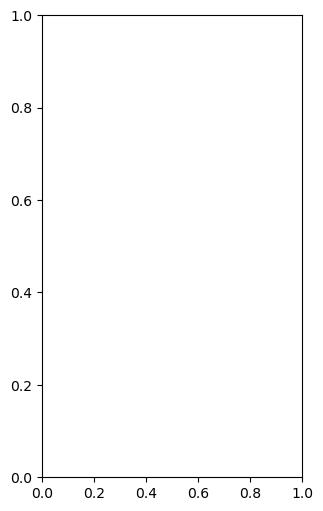

In [62]:
# Preview filtered data
df.geometry.plot(figsize=(6, 6))
plt.axis('off')
plt.show()

In [ ]:
# Folium wants coordinate system: EPSG:4326. OK!
df.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

#### Export to GeoJSON
Below, the tag (type) of each polygon is found, irrelevant data is removed, and the final data-frame is serialized and saved as GeoJSON.

The export location is "data/latest_export.json".

In [ ]:
# Construct type column
df_stripped = []
for _, r in df.iterrows():
    found_tag = None
    for tag in tags:
        if str(r[tag]) != 'nan':
            #if found_tag != None: raise Exception("Ambiguity found!")
            found_tag = tag
    df_stripped.append({'type': found_tag, 'geometry': r.geometry})

df_stripped = gpd.GeoDataFrame(df_stripped)
#print(df_stripped)
df_stripped.to_file(filename='data/latest_export.json', driver='GeoJSON')

#### Visualizer
Below, an interactive map of the polygons is generated. The different types are represented by different fill colors.

By setting SHOW_TILES to True, the OSM is rendered in the background. Setting it to False allows for a more obvious visualization of the polygons.

In [ ]:
SHOW_TILES = True

colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']
tag_colors = {x: colors[idx % len(colors)] for idx, x in enumerate(tags)}

map = folium.Map(location=[origin[0], origin[1]], zoom_start=14, tiles='CartoDB positron' if SHOW_TILES else None)

for _, r in df_stripped.iterrows():
    geo = gpd.GeoSeries(r['geometry']) # Parse Geometry for row to generate JSON
    geo = gpd.GeoDataFrame({'type': r['type'], 'geometry': geo}) # Type is needed for coloring
    geo_json = geo.to_json()
    geo_json = folium.GeoJson(data=geo_json,
                           style_function=lambda x: {
                                'weight': '1',
                                'fillOpacity': '0.7',
                                'fillColor': tag_colors[x['properties']['type']]
                            })
    geo_json.add_to(map)

map

#### Statistics of dataset

In [63]:
IMPORT_INTERSECTION_DATA = False
EXPORT_INTERSECTION_DATA = True
INCL_INTERSECTION_DATA = True

op_df = df_stripped.copy()
display(op_df)

,type,geometry
0,highway,"LINESTRING (13.22188 55.71294, 13.22146 55.711..."
1,highway,"LINESTRING (13.18544 55.70672, 13.18547 55.706..."
2,highway,"LINESTRING (13.17673 55.71512, 13.17726 55.715..."
3,highway,"LINESTRING (13.18503 55.70764, 13.18498 55.707..."
4,highway,"LINESTRING (13.18701 55.70700, 13.18686 55.70699)"
...,...,...
16629,highway,"POLYGON ((13.16994 55.70209, 13.17017 55.70208..."
16630,building,"POLYGON ((13.22121 55.69633, 13.22041 55.69653..."
16631,building,"POLYGON ((13.22121 55.69633, 13.22150 55.69670..."
16632,highway,"POLYGON ((13.18118 55.69726, 13.18113 55.69722..."


In [64]:
if IMPORT_INTERSECTION_DATA:
    op_df = pd.read_csv('./intersection_df')
    op_df['geometry'] = op_df['geometry'].apply(lambda x: shapely.wkt.loads(x))

In [65]:
def nbr_verticies(geometry):
    return  shapely.count_coordinates(geometry)

def geo_length(geometry):
    return  shapely.length(geometry)

def geo_area(geometry):
 return shapely.area(geometry)

def geo_type(geometry):
    return geometry.geom_type

def count_intersections(geometry):
    geo1_total = 0
    for geo2 in df_stripped['geometry']:
        if not shapely.equals_exact(geometry, geo2):
            if shapely.intersects(geometry, geo2):
                geo1_total += 1
    return geo1_total

In [66]:
if INCL_INTERSECTION_DATA and not IMPORT_INTERSECTION_DATA:
    op_df["intersection"] = op_df['geometry'].apply(lambda x: count_intersections(x))

    
op_df["area"] = op_df['geometry'].apply(lambda x: geo_area(x))
op_df["length"] = op_df['geometry'].apply(lambda x: geo_length(x))
op_df["verticies"] = op_df['geometry'].apply(lambda x: nbr_verticies(x))
op_df["type"] = op_df['geometry'].apply(lambda x: geo_type(x))

In [ ]:
if EXPORT_INTERSECTION_DATA:
    op_df.to_csv('./intersection_df')

In [ ]:
op_df["convex_hull"] = op_df['geometry'].apply(lambda x: shapely.count_coordinates(shapely.convex_hull(x)))

ValueError: Could not interpret input 'intersection'

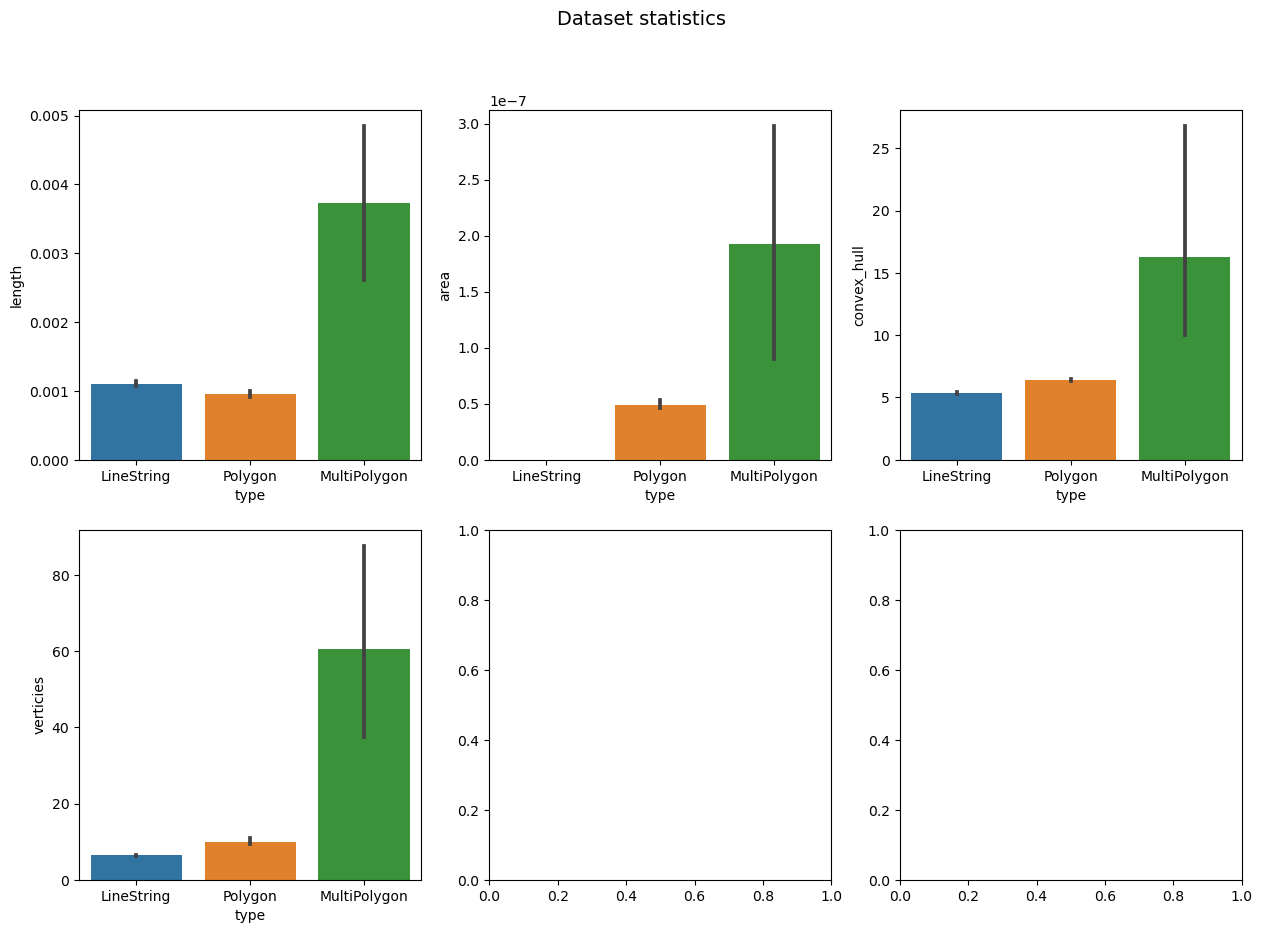

In [ ]:
figure, axis = plt.subplots(2, 3)
figure.set_figwidth(15)
figure.set_figheight(10)
figure.suptitle("Dataset statistics", fontsize=14)
sns.barplot(data=op_df, x='type', y='area',ax=axis[0,1])
sns.barplot(data=op_df, x='type', y='length',ax=axis[0,0])
sns.barplot(data=op_df, x='type', y='verticies',ax=axis[1,0])
sns.barplot(data=op_df, x='type', y='convex_hull',ax=axis[0,2])

if INCL_INTERSECTION_DATA:
    sns.barplot(data=op_df, x='type', y='intersection',ax=axis[1,2])
    
g = sns.countplot(x=op_df["type"],ax=axis[1,1])
g.set_yscale("log")
plt.tight_layout()
plt.show()